In [1]:
!pip install pymorphy2 > None

In [2]:
import json
import numpy as np
import os
import pandas as pd
import dill
import tensorflow as tf
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from random import randint, random
from sklearn.metrics.pairwise import euclidean_distances as ED
from tensorflow import keras
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

import gc

from scipy import spatial

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
tqdm.pandas()

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
%cd gdrive/MyDrive/recsys/

/content/gdrive/MyDrive/recsys


In [8]:
SEED = 2022
K_RECOS = 10

## Get data

In [9]:
def load_data():
  interactions = pd.read_csv('kion_train/interactions.csv')
  users = pd.read_csv('kion_train/users.csv')
  items = pd.read_csv('kion_train/items.csv')
  interactions.rename(
    columns={
        'last_watch_dt': 'datetime',
        'total_dur': 'weight',
    },
    inplace=True,
  )

  interactions['datetime'] = pd.to_datetime(interactions['datetime'])
  return interactions, users, items

In [10]:
interactions_df, users_df, items_df = load_data()

In [11]:
users_df = users_df[users_df['user_id'].isin(interactions_df['user_id'])]
items_df = items_df[items_df['item_id'].isin(interactions_df['item_id'])]

## Prepare user features

In [12]:
user_cat_feats = ["age", "income", "sex", "kids_flg"]
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()

,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,sex_Ж,sex_М,kids_flg_0,kids_flg_1
0,973171,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,962099,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
3,721985,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
4,704055,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
5,1037719,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0


## Prepare item features

In [13]:
items_df["country"] = items_df["countries"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
items_df["country"] = items_df["country"].fillna(' ')
items_df["country"] = items_df["country"].apply(lambda x: x[0])
items_df.head(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,country
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",испания


In [14]:
items_df['country'].nunique()

86

In [15]:
item_cat_feats = ['content_type', 'for_kids', 'age_rating', 'studios', 'country']

items_ohe_df = items_df.item_id

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

items_ohe_df.head()


,item_id,content_type_film,content_type_series,for_kids_0.0,for_kids_1.0,age_rating_0.0,age_rating_6.0,age_rating_12.0,age_rating_16.0,age_rating_18.0,...,country_хорватия,country_чехия,country_чили,country_швейцария,country_швеция,country_эквадор,country_эстония,country_юар,country_югославия,country_япония
0,10711,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2508,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10716,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7868,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,16268,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Filter interactions

Filter out unpopular items and users

In [16]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

interactions_df = interactions_df[interactions_df.watched_pct > 10]


valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > 5:
        valid_users.append(user_id)

valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 962179
N items before: 15706

N users after: 170681
N items after: 6901


In [17]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_ohe_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_ohe_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_ohe_df = items_ohe_df[items_ohe_df.item_id.isin(common_items)]
users_ohe_df = users_ohe_df[users_ohe_df.user_id.isin(common_users)]

139209
6901


In [18]:
del common_users, common_items
gc.collect()

32

## Build interactions matrix

In [19]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

interactions_df.head()

,user_id,item_id,datetime,weight,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72.0,22413,3945
1,699317,1659,2021-05-29,8317,100.0,88768,675
3,864613,7638,2021-07-05,14483,100.0,109925,3163
6,1016458,354,2021-08-14,1672,25.0,128826,139
7,884009,693,2021-08-04,703,14.0,112355,279


In [20]:
interactions_df.head()

,user_id,item_id,datetime,weight,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72.0,22413,3945
1,699317,1659,2021-05-29,8317,100.0,88768,675
3,864613,7638,2021-07-05,14483,100.0,109925,3163
6,1016458,354,2021-08-14,1672,25.0,128826,139
7,884009,693,2021-08-04,703,14.0,112355,279


In [21]:
interactions_vec = np.zeros((interactions_df.uid.nunique(), interactions_df.iid.nunique())) 

for user_id, item_id in zip(interactions_df.uid, interactions_df.iid):
    interactions_vec[user_id, item_id] += 1

res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]

In [22]:
items_ohe_df = items_ohe_df[items_ohe_df['item_id'] != 11805]
print(interactions_df.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(interactions_df.user_id.nunique())
print(users_ohe_df.user_id.nunique())

print(set(items_ohe_df.item_id.unique()) - set(interactions_df.item_id.unique()))

6900
6900
139209
139209
set()


## Mappings

In [23]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]


In [24]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe_df = users_ohe_df.set_index("uid")

## Loss

In [25]:
def triplet_loss(y_true, y_pred, n_dims=128, alpha=0.4):
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)
 
    return loss

## Text features

In [26]:
pd.set_option('max_colwidth', 200) 

In [27]:
items_df['description'].head()

0    Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий.  Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляе...
1    Уморительная современная комедия на популярную тему о том, как не надо отмечать мальчишник. Главный герой усвоил, что не надо звать на свадьбу своего друга Джейсона, из-за которого он вместо сваде...
2    Профессиональный рестлер Стив Остин («Все или ничего») и темнокожий мачо Майкл Джей Уайт («Темный рыцарь») в интригующем криминальном боевике. В центре сюжета – команда спецназовцев, которая оказа...
3    Шарлотта Рэмплинг, Том Кортни, Джеральдин Джеймс и Долли Уэллс в драме Эндрю Хэйя.  Супруги Кейт и Джефф Мерсеры готовятся к важной дате – с того дня, как они поженились, прошло целых сорок пять л...
4    Расчетливая чаровница из советского кинохита «Мой ласковый и нежный зверь», актриса-дебютантка Галина Беляева снова становится неопытным и робким подростком в спортивном фильм

### Normalization

In [28]:
items_df['description'] = items_df['description'].fillna('')

In [29]:
def normalize(text):
    res = [w.strip(punct) for w in word_tokenize(text)]
    res = [w.lower() for w in res if w != '']
    return res

In [30]:
punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~„“«»†*\—/\-‘’–'

items_df['cleaned_description'] = items_df['description'].apply(lambda x: normalize(x))

### Filter stopwords

In [31]:
sw = stopwords.words('russian')

In [32]:
def filter_sw(text):
    return [w for w in text if w not in sw]

In [33]:
items_df['cleaned_description'] = items_df['cleaned_description'].apply(lambda x: filter_sw(x))

### Lemmatization

In [34]:
%%time

morph = MorphAnalyzer()

items_df['cleaned_description'] = items_df['cleaned_description'].progress_apply(lambda x: [morph.parse(w)[0].normalized.word for w in x])

100%|██████████| 15706/15706 [02:34<00:00, 101.80it/s]

CPU times: user 2min 32s, sys: 879 ms, total: 2min 33s
Wall time: 2min 34s


In [35]:
items_df['cleaned_description'].head(1)

0    [мелодрама, легендарный, педро, альмодовар, поговорить, 2003, год, получить, премия, оскар, хороший, сценарий, журналист, марко, брать, интервью, знаменитый, женщина-тореро, лидий, вскоре, влюблят...
Name: cleaned_description, dtype: object

### BoW vectorization

In [36]:
items_df['cleaned_description'] = items_df['cleaned_description'].apply(lambda x: ' '.join(x))

In [37]:
vectorizer = CountVectorizer(min_df=5, max_features=350)
text_vectorized = pd.DataFrame(vectorizer.fit_transform(items_df['cleaned_description']).toarray(), columns=vectorizer.get_feature_names())
text_vectorized.shape

(15706, 350)

In [38]:
text_vectorized.head()

,агент,актёр,александр,американский,андрей,анна,благодаря,близкий,богатый,больший,...,часть,человек,что,чувство,чёрный,школа,это,этот,юный,являться
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
text_vectorized['item_id'] = items_df['item_id']
items_ohe_df = items_ohe_df.merge(text_vectorized, on='item_id', how='left')
items_ohe_df = items_ohe_df.fillna(0)

In [40]:
del text_vectorized, interactions_df
gc.collect()

462

## Generator

In [41]:
tree = spatial.cKDTree(items_ohe_df.drop(["item_id"], axis=1))

In [42]:
def generator(items, users, interactions, batch_size=32):
    while True:
        uid_meta = []
        uid_interaction = []
        pos = []
        neg = []
        for _ in range(batch_size):
            while True:
                try:
                    # Random user
                    uid_iid = randint(0, interactions.shape[0]-1)

                    # Sample positive item
                    pos_iid = np.random.choice(range(interactions.shape[1]), p=interactions[uid_iid])

                    # Get 20 most closest items from KDTree
                    distances, indices = tree.query(items.iloc[pos_iid].values, k=30)


                    # Filter to sample only negative item
                    pos_ids = np.nonzero(interactions[uid_iid])
                    neg_items_candidates = indices[np.in1d(indices, pos_ids, invert=True)]
                    neg_iid = np.random.choice(neg_items_candidates)
                    
                    #neg_iid = np.random.choice(range(interactions.shape[1]))
                    
                    # Negative item features
                    neg.append(items.iloc[neg_iid - 1])
                    
                    # User features
                    uid_meta.append(users.iloc[uid_iid])

                    # User's items
                    uid_interaction.append(interactions_vec[uid_iid])

                    # Positive item features
                    pos.append(items.iloc[pos_iid])
                    break
                except:
                    continue
        yield [np.array(uid_meta), np.array(uid_interaction), np.array(pos), np.array(neg)], [np.array(uid_meta), np.array(uid_interaction)]



In [43]:
# инициализируем генератор
gen = generator(
    items=items_ohe_df.drop(["item_id"], axis=1), 
    users=users_ohe_df.drop(["user_id"], axis=1), 
    interactions=interactions_vec,
)

ret = next(gen)


print(f"вектор фичей юзера: {ret[0][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[0][1].shape}")
print(f"вектор 'хорошего' айтема: {ret[0][2].shape}")
print(f"вектор 'плохого' айтема: {ret[0][3].shape}")
print()
print(f"вектор фичей юзера: {ret[1][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[1][1].shape}")

вектор фичей юзера: (32, 16)
вектор взаимодействий юзера с айтемами: (32, 6900)
вектор 'хорошего' айтема: (32, 484)
вектор 'плохого' айтема: (32, 484)

вектор фичей юзера: (32, 16)
вектор взаимодействий юзера с айтемами: (32, 6900)


## Models

In [44]:
N_FACTORS = 128

ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], ) 
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}") # add text features
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (484,)
USER_META_MODEL_SHAPE: (16,)
USER_INTERACTION_MODEL_SHAPE: (6900,)


In [45]:
def item_model(n_factors=N_FACTORS):
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
    
    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)

    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)
    
    add = keras.layers.Add()([layer_1, layer_2])
    
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)
    
    return keras.models.Model(inp, out)

In [46]:
def user_model(n_factors=N_FACTORS):
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)

    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)

    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)
    

    add = keras.layers.Add()([layer_1_meta, layer_2_meta])
    
    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])
    
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)
    
    return keras.models.Model([inp_meta, inp_interaction], out)

In [47]:
i2v = item_model()
u2v = user_model()

In [48]:
ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

ancor = u2v([ancor_meta_in, ancor_interaction_in])
pos = i2v(pos_in)
neg = i2v(neg_in)

res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

In [49]:
model_name = 'recsys_resnet_linear'

decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.8, verbose=1)
early_stopping =  keras.callbacks.EarlyStopping(monitor='loss', patience=4)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss=triplet_loss, optimizer=opt, run_eagerly=True)

In [50]:
item_model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 484)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          61952       ['input_8[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 128)          16384       ['dense_7[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 128)          0           ['dense_7[0][0]',                
                                                                  'dense_8[0][0]']          

In [51]:
user_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          2048        ['input_9[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 128)          16384       ['dense_10[0][0]']               
                                                                                                  
 input_10 (InputLayer)          [(None, 6900)]       0           []                               
                                                                                            

In [52]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 6900)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 484)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 484)]        0           []                               
                                                                                            

In [53]:
model.fit(
    generator(
        items=items_ohe_df.drop(["item_id"], axis=1), 
        users=users_ohe_df.drop(["user_id"], axis=1), 
        interactions=interactions_vec,
        batch_size=16,
    ), 
    steps_per_epoch=100, 
    epochs=100, 
    initial_epoch=0,
    callbacks=[decay, early_stopping],
)


Epoch 1/100
100/100 [==============================] - 16s 149ms/step - loss: 2.6121 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 15s 150ms/step - loss: 0.9784 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 15s 150ms/step - loss: 0.7146 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 15s 151ms/step - loss: 0.5505 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 15s 150ms/step - loss: 0.5029 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 15s 151ms/step - loss: 0.4678 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 15s 151ms/step - loss: 0.4355 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 15s 153ms/step - loss: 0.4697 - lr: 0.0010
Epoch 9/100
100/100 [==============================] - 15s 152ms/step - loss: 0.3521 - lr: 0.0010
Epoch 10/100
100/100 [==============================] - 15s 151ms/step - loss: 0.3473 - lr: 0.0010
Epoch 11/100
100/10

In [54]:
#model.save('model')

In [55]:
items_feats = items_ohe_df.drop(["item_id"], axis=1).to_numpy()
items_vecs = i2v.predict(items_feats)

216/216 [==============================] - 0s 1ms/step


In [56]:
del items_feats, users_df, items_df, items_ohe_df, model
gc.collect()

714

In [57]:
def get_recs_for_user_batch(user_ids):
  uids = [user_id_to_uid[user_id] for user_id in user_ids]
  user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[uids]
  user_interaction_vec = interactions_vec[uids]

  user_vecs = u2v.predict([np.array(user_meta_feats), np.array(user_interaction_vec)])

  dists = ED(user_vecs, items_vecs)
  top10_iids = np.argsort(dists, axis=1)[:,:10]
  top10_iids_items = [iid_to_item_id[iid] for iid in top10_iids.reshape(-1)]
  top10_iids_items = np.array(top10_iids_items).reshape(top10_iids.shape)
  return top10_iids_items

## Prepare submit

In [58]:
submission = pd.read_csv('sample_submission.csv')

In [59]:
recs = pd.DataFrame({'user_id': submission['user_id'].unique()})
cold = recs[~recs['user_id'].isin(users_ohe_df.user_id)]
warm = recs[recs['user_id'].isin(users_ohe_df.user_id)]

In [60]:
cold_recs = [[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734] for i in range(len(cold['user_id']))]
cold_recs = pd.DataFrame(list(zip(cold['user_id'].values.tolist(), cold_recs)), columns=['user_id', 'item_id'])
cold_recs.head()

,user_id,item_id
0,3,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
1,29,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
2,30,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
3,33,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"
4,39,"[9728, 10440, 15297, 13865, 14488, 12192, 12360, 341, 4151, 3734]"


In [61]:
res = []
for df in tqdm(np.array_split(warm, 20)):
  res.append(get_recs_for_user_batch(df['user_id'].values))

  0%|          | 0/20 [00:00<?, ?it/s]

72/72 [==============================] - 0s 2ms/step


  5%|▌         | 1/20 [00:02<00:40,  2.11s/it]

72/72 [==============================] - 0s 2ms/step


 10%|█         | 2/20 [00:03<00:34,  1.90s/it]

72/72 [==============================] - 0s 2ms/step


 15%|█▌        | 3/20 [00:05<00:31,  1.83s/it]

72/72 [==============================] - 0s 2ms/step


 20%|██        | 4/20 [00:07<00:27,  1.74s/it]

72/72 [==============================] - 0s 2ms/step


 25%|██▌       | 5/20 [00:08<00:25,  1.69s/it]

72/72 [==============================] - 0s 2ms/step


 30%|███       | 6/20 [00:10<00:23,  1.66s/it]

72/72 [==============================] - 0s 2ms/step


 35%|███▌      | 7/20 [00:12<00:21,  1.64s/it]

72/72 [==============================] - 0s 2ms/step


 40%|████      | 8/20 [00:13<00:19,  1.62s/it]

72/72 [==============================] - 0s 2ms/step


 45%|████▌     | 9/20 [00:15<00:17,  1.60s/it]

72/72 [==============================] - 0s 2ms/step


 50%|█████     | 10/20 [00:16<00:16,  1.64s/it]

72/72 [==============================] - 0s 2ms/step


 55%|█████▌    | 11/20 [00:18<00:14,  1.62s/it]

72/72 [==============================] - 0s 2ms/step


 60%|██████    | 12/20 [00:20<00:12,  1.61s/it]

72/72 [==============================] - 0s 2ms/step


 65%|██████▌   | 13/20 [00:21<00:11,  1.62s/it]

72/72 [==============================] - 0s 2ms/step


 70%|███████   | 14/20 [00:23<00:09,  1.60s/it]

72/72 [==============================] - 0s 2ms/step


 75%|███████▌  | 15/20 [00:24<00:08,  1.64s/it]

72/72 [==============================] - 0s 2ms/step


 80%|████████  | 16/20 [00:26<00:06,  1.62s/it]

72/72 [==============================] - 0s 2ms/step


 85%|████████▌ | 17/20 [00:28<00:04,  1.67s/it]

72/72 [==============================] - 0s 2ms/step


 90%|█████████ | 18/20 [00:29<00:03,  1.64s/it]

72/72 [==============================] - 0s 2ms/step


 95%|█████████▌| 19/20 [00:31<00:01,  1.62s/it]

72/72 [==============================] - 0s 2ms/step


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


In [62]:
warm['item_id'] = np.concatenate(res).tolist()

In [63]:
warm.head()

,user_id,item_id
1,11,"[13865, 11237, 3817, 8617, 14159, 1626, 13159, 6794, 7706, 2916]"
6,46,"[13865, 11237, 8617, 4470, 13159, 3817, 6794, 14159, 521, 3363]"
7,47,"[13865, 11237, 8617, 3817, 13159, 14159, 512, 2916, 6646, 15262]"
15,93,"[11237, 13865, 13159, 8617, 3817, 512, 3363, 4470, 14159, 15262]"
22,118,"[13865, 6794, 11237, 2916, 4718, 1626, 521, 512, 12156, 12033]"


In [64]:
res = pd.concat((cold_recs, warm))
assert res.shape[0] == submission.shape[0]
res.to_csv('dssm_2.csv', index=False)

## Submit results

### Simple DSSM with "good" sampling

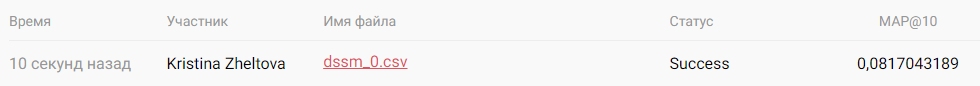

### DSSM with good sampling and text features

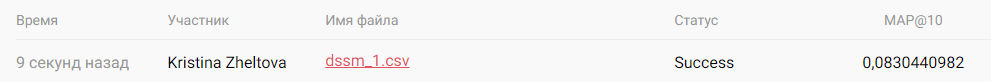

### DSSM with good sampling, text features and optimal epochs

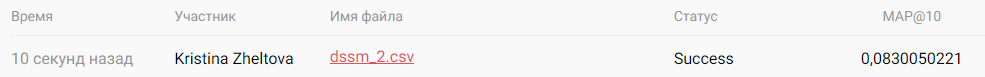